In [1]:
using Random

In [2]:
using LinearAlgebra

In [3]:
using Statistics

In [4]:
using Plots

# Monte Carlo sampling for evaluation of partition functions

## Metropolis

Let's implement the Metropolis algorithm for the 2D Ising model. For configurations, we'll use the same storage scheme as before.

In [5]:
spin(b::Bool) = Float64(2 * b - 1)

spin (generic function with 1 method)

To allow us to study different topologies, we will use a separate function to define what we mean by neighbouring sites.

In [6]:
neighbours_2D_PBC(nx::Int, ny::Int, Lx::Int, Ly::Int) = ((mod1(nx+1, Lx), ny), (mod1(nx-1, Lx), ny), 
    (nx, mod1(ny+1, Ly)), (nx, mod1(ny-1, Ly)))

neighbours_2D_PBC (generic function with 1 method)

Now we can actually implement the Metropolis update. This takes the configuration, as well as the coordinates nx and ny of a spin to try to flip.

In [7]:
function ising_metupd_2D_PBC!(c::BitArray{2}, nx::Int, ny::Int, h::Float64, Jx::Float64, Jy::Float64, β::Float64)
    Ly,Lx = size(c)
    
    nb_x1, nb_x2, nb_y1, nb_y2 = neighbours_2D_PBC(nx, ny, Lx, Ly)
    
    b = c[ny,nx]
    
    s = spin(b)
    sn_x = spin(c[nb_x1[2], nb_x1[1]]) + spin(c[nb_x2[2], nb_x2[1]])
    sn_y = spin(c[nb_y1[2], nb_y1[1]]) + spin(c[nb_y2[2], nb_y2[1]])
    
    e = -(h + Jx * sn_x + Jy * sn_y)
    
    amp = exp(2β * s * e)
    
    accept = rand() < amp #If amp<1, this will set accept to true with probability amp. If amp > 1, accept is always false.
    if accept
        c[ny, nx] = !b
    end
    
    accept
end

ising_metupd_2D_PBC! (generic function with 1 method)

Let's see what kind of configurations we can generate.

In [8]:
c = bitrand(10,10)

10×10 BitArray{2}:
  true   true  false  false   true   true  false   true  false   true
  true  false   true   true   true  false  false   true   true   true
  true   true  false  false   true   true  false   true   true  false
 false  false   true  false   true  false  false   true   true   true
  true   true  false  false   true   true   true  false   true  false
  true   true   true  false   true  false   true   true   true  false
  true   true   true  false  false   true   true  false  false  false
 false  false  false   true  false   true   true  false   true  false
  true   true   true   true  false   true   true   true  false  false
  true  false   true  false   true   true  false  false  false   true

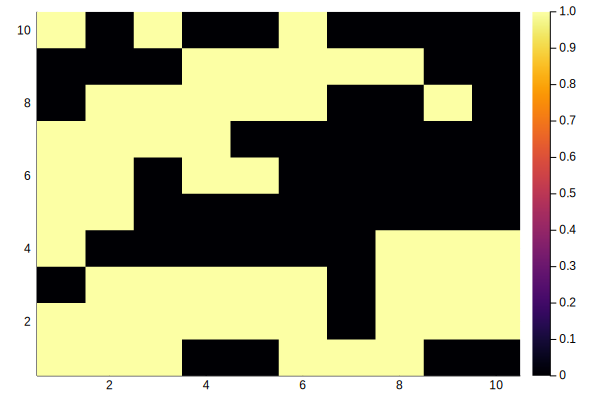

In [9]:
let h = 0.0, Jx = 1.0, Jy = 1.0, T = 2.269
    Ly,Lx = size(c)
    for j in 1:Lx*Ly
        nx = rand(1:Lx)
        ny = rand(1:Ly)
        ising_metupd_2D_PBC!(c, nx, ny, h, Jx, Jy, 1/T)
    end
    heatmap(c)
end

## Estimating a variable

We wish to estimate the magnetisation. First, we define a function to evaluate it on a configuration.

In [10]:
function ising_mag_2D_PBC(c::BitArray{2})::Float64
    Ly,Lx = size(c)
    N = Lx * Ly
    Nup = count(c) #counts the number of spins set to "true"
    
    (2Nup - N) / N
end

ising_mag_2D_PBC (generic function with 1 method)

This function evaluate the magnetization and adds it to a preexisting results array. It does the same for $M^2$. We will use this for sampling expectation values.

In [11]:
function ising_meas_mag_2D_PBC!(meas::AbstractMatrix{Float64}, nsweep::Int, c::BitArray{2})
    m = ising_mag_2D_PBC(c)
    
    #write to the results array
    meas[1,nsweep] = meas[1,nsweep] + m
    meas[2,nsweep] = meas[2,nsweep] + m^2
end

ising_meas_mag_2D_PBC! (generic function with 1 method)

Next let's define a function to gather measurements over a number of sweeps. We will take a "measfunc" argument that specifies a function that carried out the measurement. This way we can use this Monte-Carlo sampling routine for any measurement we want.

In [12]:
function ising_MC_2D_PBC(c::BitArray{2}, h::Float64, Jx::Float64, Jy::Float64, β::Float64, Nsweeps::Int; 
                         keep_cs::Bool=false, Nmeas::Int=2, measfunc=ising_meas_mag_2D_PBC!)
    Ly, Lx = size(c)
    N = Lx * Ly
    
    cs = BitArray{2}[]
    
    ms = zeros((Nmeas, Nsweeps))
    
    Racc = zeros(Nsweeps)
    
    for i in 1:Nsweeps
        acc = 0
        for j in 1:N
            nx = rand(1:Lx)
            ny = rand(1:Ly)
            acc += ising_metupd_2D_PBC!(c, nx, ny, h, Jx, Jy, β)
        end
        measfunc(ms, i, c)
        Racc[i] = acc / N
        if keep_cs
            push!(cs, copy(c))
        end
    end
    
    #rmul!(ms, 1/N)
    
    keep_cs ? (ms, Racc, cs) : ms, Racc
end

ising_MC_2D_PBC (generic function with 1 method)

In [13]:
time_ising_MC(c, nswp) = @time ising_MC_2D_PBC(c, 0.0, 1.0, 1.0, 1/2.269, nswp)

time_ising_MC (generic function with 1 method)

In [14]:
let c = bitrand(10,10), nswp = 1000
    time_ising_MC(c, nswp)
end;

  0.010202 seconds (4 allocations: 23.797 KiB)


### Getting results

To avoid autocorrelation effects, which lead to underestimation of the error, and also to exploit the central limit theorem, we use "binning". Binning is the division of measurements into blocks of $l_{\text{bin}}$ sequential measurements. The new samples are the averages within the blocks. For sufficiently large blocks, the mean of a block approximately obeys gaussian statistics, and neighbouring can be treated as independent.

In [15]:
function binmeas(meas::Vector{Float64}, lbin::Int)
    nbins, leftover = divrem(length(meas), lbin)
    to_bin = view(meas, leftover+1:length(meas)) # trim from start to help thermalization
    to_bin = reshape(to_bin, (lbin, nbins))
    binned = vec(mean(to_bin, dims=1)) # take means over bins
    binned, leftover
end

binmeas (generic function with 1 method)

Given a vector containing a sampling of `length(vector)` iid random variables, computes a sampling of the mean and estimates the standard deviation on the mean.

In [16]:
function measval(meas::Vector{Float64})
    m = mean(meas)
    m_stdev = √(varm(meas, m) / length(meas)) # stdev of the mean of iid random variables
    m, m_stdev
end

measval (generic function with 1 method)

### Test

Let's try out metropolis sampling for measuring the magnetization at the critical temperature.

  2.067963 seconds (6 allocations: 4.578 MiB)
mean(Racc) = 0.07942619999999999


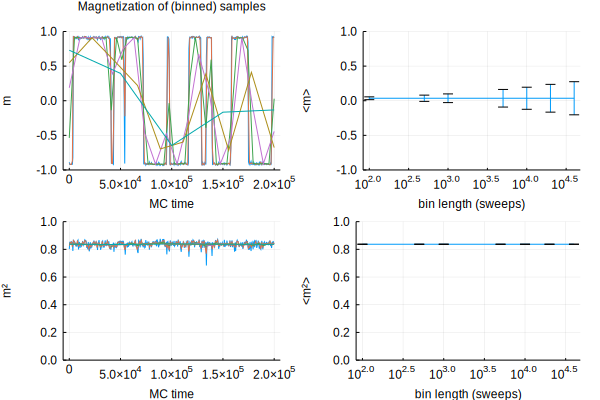

In [35]:
let Lx = 10, Ly = 10, h = +0.0, Jx = 1.0, Jy = 1.0, T = 2.0, Nsweep = 200000, Nburn = 0
    
    #Choose bin sizes
    lbins = Int[100,500,1000,5000,10000,20000,40000]
    
    N = Lx * Ly
    c = falses(Ly,Lx)
    @time meas, Racc = ising_MC_2D_PBC(c, h, Jx, Jy, 1.0/T, Nsweep, Nmeas=2, measfunc=ising_meas_mag_2D_PBC!)
    @show mean(Racc)
    
    meas = meas'
    ms = meas[:,1]
    m2s = meas[:,2]
    
    p_m_raw = plot(
        title="Magnetization of binned samples",
        xlabel="MC time", ylabel="m",
        ylim=(-1,+1)
    )
    
    ms = ms[Nburn+1:end] #burn-in
    
    avs = zeros(length(lbins))
    stds = zeros(length(lbins))
    
    for (j, lbin) in enumerate(lbins)
        msb, offset = binmeas(ms, lbin)
        if length(msb) <= 1000 # only plot binned data with a reasonable number of points
            plot!(range(Nburn+offset+1, Nsweep, length=length(msb)), msb, label="$lbin")
        end
        avs[j], stds[j] = measval(msb)
    end
    
    p_m = plot(
        lbins, avs, yerror=stds, 
        xscale=:log10,
        ylim=(-1,+1),
        xlabel="bin length (sweeps)", ylabel="<m>"
    )

 
    p_m2_raw = plot(
        ylim=(0,+1),
        xlabel="MC time", ylabel="m²"
    )
    
    m2s = m2s[Nburn+1:end] #burn-in
    
    avs = zeros(length(lbins))
    stds = zeros(length(lbins))
    
    for (j, lbin) in enumerate(lbins)
        m2sb, offset = binmeas(m2s, lbin)
        if length(m2sb) <= 1000
            plot!(range(Nburn+offset+1, Nsweep, length=length(m2sb)), m2sb, label="$lbin")
        end
        avs[j], stds[j] = measval(m2sb)
    end
    
    
    p_m2 = plot(
        lbins, avs, yerror=stds,
        xscale=:log10,
        ylim=(0,1),
        xlabel="bin length (sweeps)", ylabel="<m²>"
    )
    
    plot(p_m_raw, p_m, p_m2_raw, p_m2, layout=4, legend=false, titlefontsize=8, guidefontsize=8)
end

We see lots of jumps in the magnetization. Also, that the error bars, especially for the magnetization, grow slowly with the bin size, suggests a lot of autocorrelation. Let's have a look at the sampling procedure...

## Ergodicity

Let us evaluate the Metropolis algorithm. After burn-in, it should take us through a selection of the most probable configurations. Let's check that on a small system. We're using the same functions we used in the partition function notebook to get the true probability of each configuration.

In [18]:
function ising_weight_2D_PBC(c::BitArray{2}, h::Float64, Jx::Float64, Jy::Float64, β::Float64)::Float64
    Ly,Lx = size(c)

    en = 0.0
    @inbounds @fastmath for k in 1:Lx, j in 1:Ly
        s = spin(c[j,k])
        en -= h * s
        en -= Jx * s * spin(c[j,mod1(k+1, Lx)])
        en -= Jy * s * spin(c[mod1(j+1, Ly),k])
    end
    
    exp(-en * β)
end

ising_weight_2D_PBC (generic function with 1 method)

In [19]:
function ising_pd_2D_PBC(Lx::Int, Ly::Int, h::Float64, Jx::Float64, Jy::Float64, β::Float64)
    N = Lx*Ly
    @assert N ≤ 64 "Up to 64 spins!" #Although it would take a *long* time, our implementation would do 64!
    c = falses(Ly,Lx)
    Ws = zeros(2^N)
    Ms = zeros(2^N)
    for j in 0:2^N-1
        c.chunks[1] = j
        W = ising_weight_2D_PBC(c, h, Jx, Jy, β)
        M = ising_mag_2D_PBC(c)
        Ws[j+1] = W
        Ms[j+1] = M
    end
    Z = sum(Ws)
    
    P = Ws ./ Z #normalize the weights to probabilities
    
    P, Ms, Z
end

ising_pd_2D_PBC (generic function with 1 method)

Now let's see how well Metropolis did at the critical temperature. We will use the raw samples to estimate the probability of a correlation and compare it to the exact result. This will show us autocorrelation issues.

  0.417650 seconds (9 allocations: 24.000 MiB, 0.90% gc time)
acc / (Nsamp * meas_every) = 0.205
sum(P) = 1.0000000000000007


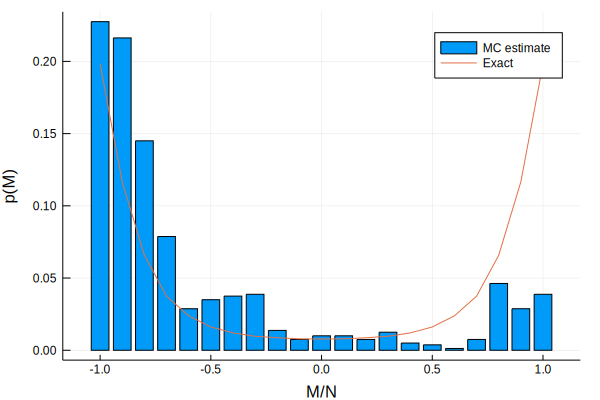

In [40]:
let Lx = 4, Ly = 5, T = 2.269, Jx = 1.0, Jy = 1.0, h = 0.0, Nburn = 100, Nsamp = 800, meas_every = 1
    N = Lx * Ly
    @time P, Ms, Z = ising_pd_2D_PBC(Lx,Ly,h,Jx,Jy,1/T)
    
    visits = zeros(Int, length(P))
    c = bitrand(Ly,Lx)
    #burn in 
    for j in 1:Nburn
        nx = rand(1:Lx)
        ny = rand(1:Ly)
        ising_metupd_2D_PBC!(c, nx, ny, h, Jx, Jy, 1.0/T)
    end
    acc = 0
    for j in 1:Nsamp
        for k in 1:meas_every
            nx = rand(1:Lx)
            ny = rand(1:Ly)
            acc += ising_metupd_2D_PBC!(c, nx, ny, h, Jx, Jy, 1.0/T)
        end
        visits[c.chunks[1] + 1] += 1
    end
    @show acc / (Nsamp * meas_every)
    F = visits / Nsamp
    
    srt = sortperm(P, rev=true)
    P = P[srt]
    Ms = Ms[srt]
    F = F[srt]
    
    @show sum(P)
    Ws = P * Z
    Es = -log.(Ws) * T

    Ms_unique = sort(unique(Ms))
    PM = zeros(length(Ms_unique))
    FM = zeros(length(Ms_unique))
    for j in 1:length(Ms_unique)
        flt = Ms .== Ms_unique[j]
        PM[j] = sum(P[flt])
        FM[j] = sum(F[flt])
    end

    bar(Ms_unique, FM, label="MC estimate", xlabel="M/N", ylabel="p(M)")
    plot!(Ms_unique, PM, label="Exact")
end

It seems the Metropolis algorithm breaks the spin-flip symmetry. This makes sense, since if we start magnetized it is very improbable to flip enough spins to cross over to the opposite magnetization, if we only flip one at a time. In other words, we expect strong autocorrelation problems, as we witnessed above. We would need to sample for a very long time to fix this. Alternatively, we can change our update algorithm.

## Cluster updates

To improve the ergodicity near the critical point, we can try a different update scheme, flipping multiple spins at once. This is the Wolff algorithm (DOI:10.1103/PhysRevLett.62.361). It adds a number of sites from an existing magnetic domain while respecting detailed balance.

In [21]:
Coord = Tuple{Int,Int}

Tuple{Int64,Int64}

In [22]:
function ising_clustupd_2D_PBC!(c::BitArray{2}, to_visit::Vector{Coord}, nx1::Int, ny1::Int, β::Float64)
    Ly,Lx = size(c)
    
    c_size = 1

    resize!(to_visit, 0)
    c[ny1, nx1] = !c[ny1, nx1] # flip first site
    push!(to_visit, (nx1,ny1)) # schedule neighbours for a visit
    
    while !isempty(to_visit)
        # this site was already added to the cluster and flipped
        (nx,ny) = pop!(to_visit)
        b = c[ny,nx]
        
        # now determine which of its neighbours to add
        for (nb_x, nb_y) in neighbours_2D_PBC(nx, ny, Lx, Ly)
            nb_b = c[nb_y,nb_x]
            
            # If neighbour is anti-aligned, add to cluster with prob 1-exp(-2β).
            # Aligned neighbours are either already in the cluster, or do not belong
            # to the original domain.
            if xor(b, nb_b) && rand() < 1.0 - exp(-2β)
                c[nb_y,nb_x] = !nb_b
                c_size += 1
                # Schedule this site's neighbours for a visit
                push!(to_visit, (nb_x, nb_y))
            end
        end
    end
    
    c_size
end

ising_clustupd_2D_PBC! (generic function with 1 method)

In [23]:
function test_clusters(Lx,Ly,itr, T=2.269)
    c = bitrand(Ly,Lx)
    to_visit = Coord[]
    #burn in 
    for j in 1:itr
        nx = rand(1:Lx)
        ny = rand(1:Ly)
        @time ising_clustupd_2D_PBC!(c, to_visit, nx, ny, 1.0/T)
    end
end

test_clusters (generic function with 2 methods)

In [24]:
test_clusters(10,10,10)

  0.000005 seconds (1 allocation: 80 bytes)
  0.000003 seconds
  0.000012 seconds (2 allocations: 416 bytes)
  0.000005 seconds
  0.000010 seconds
  0.000013 seconds (1 allocation: 544 bytes)
  0.000002 seconds
  0.000013 seconds
  0.000011 seconds
  0.000002 seconds


Occasional allocations happen when the to_visit vector needs to be substantially resized.

  0.361691 seconds (9 allocations: 24.000 MiB, 1.05% gc time)
  0.002126 seconds (1.13 k allocations: 17.594 KiB)
c_frac / N = 0.767437500000004
sum(P) = 1.0000000000000007


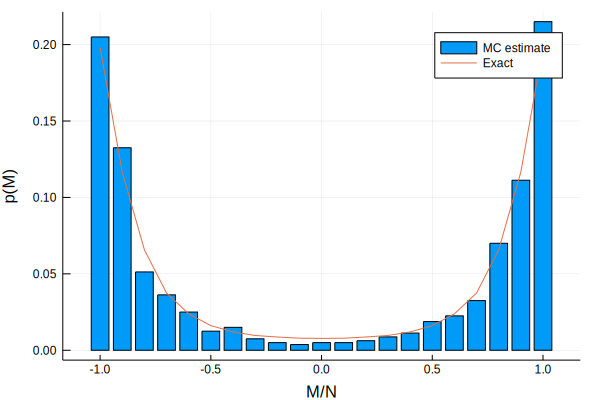

In [39]:
let Lx = 4, Ly = 5, T = 2.269, Nburn = 100, Nsamp = 800, Nupd = 1
    N = Lx * Ly
    @time P, Ms, Z = ising_pd_2D_PBC(Lx,Ly,0.0,1.0,1.0,1/T)
    
    visits = zeros(Int, length(P))
    c = bitrand(Ly,Lx)
    to_visit = Coord[]
    #burn in 
    for j in 1:Nburn
        nx = rand(1:Lx)
        ny = rand(1:Ly)
        ising_clustupd_2D_PBC!(c, to_visit, nx, ny, 1.0/T)
    end
    c_frac = 0
    @time for j in 1:Nsamp
        for k in 1:Nupd
            nx = rand(1:Lx)
            ny = rand(1:Ly)
            c_frac += ising_clustupd_2D_PBC!(c, to_visit, nx, ny, 1.0/T) / (Nsamp * Nupd)
        end
        visits[c.chunks[1] + 1] += 1
    end
    @show c_frac / N
    F = visits / Nsamp
    
    srt = sortperm(P, rev=true)
    P = P[srt]
    Ms = Ms[srt]
    F = F[srt]
    
    @show sum(P)
    Ws = P * Z
    Es = -log.(Ws) * T

    Ms_unique = sort(unique(Ms))
    PM = zeros(length(Ms_unique))
    FM = zeros(length(Ms_unique))
    for j in 1:length(Ms_unique)
        flt = Ms .== Ms_unique[j]
        PM[j] = sum(P[flt])
        FM[j] = sum(F[flt])
    end

    bar(Ms_unique, FM, label="MC estimate", xlabel="M/N", ylabel="p(M)")
    plot!(Ms_unique, PM, label="Exact")
end

This is much more symmetric than the metropolis version!

In [30]:
function ising_MC_cluster_2D_PBC(c::BitArray{2}, β::Float64, Nsweeps::Int; 
                           keep_cs::Bool=false, Nmeas::Int=2, measfunc=ising_meas_mag_2D_PBC!)
    Ly, Lx = size(c)
    N = Lx * Ly
    
    cs = BitArray{2}[]
    
    ms = zeros((Nmeas, Nsweeps))
    
    c_fracs = zeros(Nsweeps)
    
    to_visit = Coord[]
    
    for i in 1:Nsweeps
        c_frac = 0.0
        Nupd = 0
        while c_frac < 1.0 #Note: Not obviously the most sensible choice for a sweep.
            nx = rand(1:Lx)
            ny = rand(1:Ly)
            c_frac += ising_clustupd_2D_PBC!(c, to_visit, nx, ny, β)
            measfunc(ms, i, c)
            Nupd += 1
        end
        for k in 1:Nmeas
            ms[k,i] /= Nupd
        end
        
        c_fracs[i] = c_frac / Nupd
        if keep_cs
            push!(cs, copy(c))
        end
    end
    
    keep_cs ? (ms, c_fracs, cs) : ms, c_fracs
end

ising_MC_cluster_2D_PBC (generic function with 1 method)

In [31]:
test_cluster_MC(c, Nsweep, T=2.269) = @time ising_MC_cluster_2D_PBC(c, 1.0/T, Nsweep, Nmeas=2, measfunc=ising_meas_mag_2D_PBC!)

test_cluster_MC (generic function with 2 methods)

In [32]:
let c = bitrand(4,4), Nsweep = 200
    test_cluster_MC(c, Nsweep)
end;

  0.056077 seconds (46.27 k allocations: 2.311 MiB)


mean(c_fracs) = 60.72240909090909


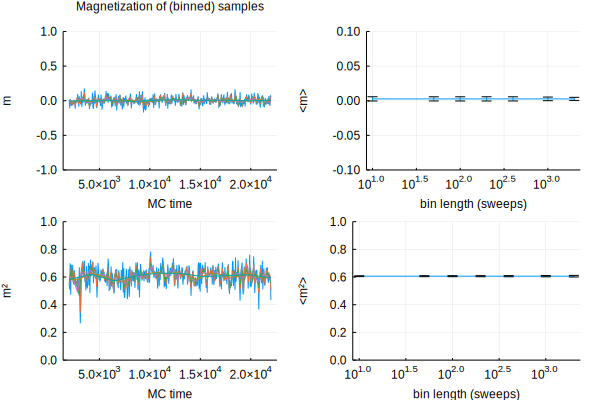

In [36]:
let Lx = 10, Ly = 10, T = 2.269, Nsweep = 22000, Nburn = 2000
    
    lbins = Int[10, 50, 100, 200, 400, 1000, 2000]
    
    N = Lx * Ly
    c = bitrand(Ly,Lx)
    meas, c_fracs = ising_MC_cluster_2D_PBC(c, 1.0/T, Nsweep, Nmeas=2, measfunc=ising_meas_mag_2D_PBC!)
    @show mean(c_fracs)
    
    meas = meas'
    ms = meas[:,1]
    m2s = meas[:,2]
    
    p_m_raw = plot(
        title="Magnetization of (binned) samples",
        xlabel="MC time", ylabel="m",
        ylim=(-1,+1)
    )
    
    ms = ms[Nburn+1:end] #burn-in
    
    avs = zeros(length(lbins))
    stds = zeros(length(lbins))
    
    for (j, lbin) in enumerate(lbins)
        msb, offset = binmeas(ms, lbin)
        if length(msb) <= 1000 # only plot binned data with a reasonable number of points
            plot!(range(Nburn+offset+1, Nsweep, length=length(msb)), msb, label="$lbin")
        end
        avs[j], stds[j] = measval(msb)
    end
    
    p_m = plot(
        lbins, avs, yerror=stds, 
        xscale=:log10,
        ylim=(-0.1,+0.1),
        xlabel="bin length (sweeps)", ylabel="<m>"
    )

 
    p_m2_raw = plot(
        ylim=(0,+1),
        xlabel="MC time", ylabel="m²"
    )
    
    m2s = m2s[Nburn+1:end] #burn-in
    
    avs = zeros(length(lbins))
    stds = zeros(length(lbins))
    
    for (j, lbin) in enumerate(lbins)
        m2sb, offset = binmeas(m2s, lbin)
        if length(m2sb) <= 1000
            plot!(range(Nburn+offset+1, Nsweep, length=length(m2sb)), m2sb, label="$lbin")
        end
        avs[j], stds[j] = measval(m2sb)
    end
    
    
    p_m2 = plot(
        lbins, avs, yerror=stds,
        xscale=:log10,
        ylim=(0,1),
        xlabel="bin length (sweeps)", ylabel="<m²>"
    )
    
    plot(p_m_raw, p_m, p_m2_raw, p_m2, layout=4, legend=false, titlefontsize=8, guidefontsize=8)
end

We observe a lack of jumps in the magnetization, much better convergence of the error bars with bin size, and much smaller errors!